In [1]:
# for basic operations
import pandas as pd
import numpy as np

# for network analysis
import networkx as nx

# for looping
from tqdm import tqdm

# for statistics
from statistics import median

# for data visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# for warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# lets read the dataset
data = pd.read_csv('ipl_batting_partnerships.csv')

# lets check the shape of the data
data.shape


(424, 6)

In [4]:
# lets check the columns
data.columns

Index(['index', 'team', 'player_1', 'player_2', 'score_1', 'score_2'], dtype='object')

In [5]:
# lets check the head of the data
data.head()

,index,team,player_1,player_2,score_1,score_2
0,0,Chennai Super Kings,AT Rayudu,SR Watson,7,0
1,1,Chennai Super Kings,AT Rayudu,SK Raina,12,19
2,2,Chennai Super Kings,AT Rayudu,KM Jadhav,9,9
3,3,Chennai Super Kings,RA Jadeja,KM Jadhav,6,4
4,19,Sunrisers Hyderabad,DA Warner,JM Bairstow,74,39


Every row in the dataset represents a batting partnership. The columns player_1 and player_2 contain the batsmen pairs and the columns score_1 and score_2 are the runs scored by them in their respective partnerships, respectively.

In [7]:

# prepare dataframe for Delhi Capitals
df_dc = data[data['team']=="Delhi Capitals"]

df_dc['partners'] = [sorted([i,j]) for i,j in zip(df_dc['player_1'], df_dc['player_2'])]
df_dc['partnership'] = ["".join(i) for i in df_dc['partners']]

df_dc.head()

,index,team,player_1,player_2,score_1,score_2,partners,partnership
17,32,Delhi Capitals,S Dhawan,PP Shaw,2,7,"[PP Shaw, S Dhawan]",PP ShawS Dhawan
18,33,Delhi Capitals,S Dhawan,SS Iyer,2,16,"[S Dhawan, SS Iyer]",S DhawanSS Iyer
19,34,Delhi Capitals,S Dhawan,CA Ingram,36,47,"[CA Ingram, S Dhawan]",CA IngramS Dhawan
20,35,Delhi Capitals,S Dhawan,RR Pant,3,16,"[RR Pant, S Dhawan]",RR PantS Dhawan
21,36,Delhi Capitals,KMA Paul,RR Pant,3,21,"[KMA Paul, RR Pant]",KMA PaulRR Pant


In [8]:
# empty list to store players name
p1 = []
p2 = []

# empty lists to store median of runs scored
r1 = []
r2 = []

for p in df_dc['partnership'].unique():
    
    temp = df_dc[df_dc['partnership'] == p]
    p1.append(temp.iloc[0]['player_1'])
    p2.append(temp.iloc[0]['player_2'])
    
    a = []
    b = []
    
    # extract individual scores for both the players
    for index, row in temp.iterrows():
        # scores of player 1
        a.append(row['score_1'])
        
        # scores of player 2
        b.append(row['score_2'])

    # append median of scores    
    r1.append(median(a))
    r2.append(median(b))

In [9]:
# aggregated batting-partnership data
team_df = pd.DataFrame({'p1':p1, 'p2':p2, 'r1':r1, 'r2':r2})
team_df.head()

,p1,p2,r1,r2
0,S Dhawan,PP Shaw,13.0,11.0
1,S Dhawan,SS Iyer,21.5,23.0
2,S Dhawan,CA Ingram,4.0,14.0
3,S Dhawan,RR Pant,8.0,20.5
4,KMA Paul,RR Pant,3.0,13.0


In [11]:
# find the leading batsman
team_df['lead'] = np.where(team_df['r1'] >= team_df['r2'], team_df['p1'], team_df['p2'])
team_df['follower'] = np.where(team_df['lead'] == team_df['p1'], team_df['p2'], team_df['p1'])
team_df['larger_score'] = np.where(team_df['r1'] >= team_df['r2'], team_df['r1'], team_df['r2'])
team_df['total_score'] = team_df['r1'] + team_df['r2']

# performance ratio
team_df['performance'] = team_df['larger_score']/(team_df['total_score']+0.01)

In [12]:
team_df.head()

,p1,p2,r1,r2,lead,follower,larger_score,total_score,performance
0,S Dhawan,PP Shaw,13.0,11.0,S Dhawan,PP Shaw,13.0,24.0,0.541441
1,S Dhawan,SS Iyer,21.5,23.0,SS Iyer,S Dhawan,23.0,44.5,0.516738
2,S Dhawan,CA Ingram,4.0,14.0,CA Ingram,S Dhawan,14.0,18.0,0.777346
3,S Dhawan,RR Pant,8.0,20.5,RR Pant,S Dhawan,20.5,28.5,0.719046
4,KMA Paul,RR Pant,3.0,13.0,RR Pant,KMA Paul,13.0,16.0,0.811993


In [32]:
# top 10 performance
team_df[['lead',
         'follower',
         'performance']].sort_values(by = 'performance',
                                     ascending = False).head(10).style.background_gradient(cmap = 'Wistia')

,lead,follower,performance
27,AR Patel,I Sharma,0.999286
46,RR Pant,A Mishra,0.998336
19,Avesh Khan,K Rabada,0.997506
45,KMA Paul,TA Boult,0.997506
7,S Dhawan,KMA Paul,0.990099
28,CH Morris,RR Pant,0.990099
14,CA Ingram,HV Patel,0.990099
40,J Suchith,SS Iyer,0.990099
29,C Munro,S Dhawan,0.874271
38,CA Ingram,SE Rutherford,0.832639


In [33]:
# bottom 10 performance
team_df[['lead',
         'follower',
         'performance']].sort_values(by = 'performance',
                                     ascending = False).tail(10).style.background_gradient(cmap = 'Wistia')

,lead,follower,performance
0,S Dhawan,PP Shaw,0.541441
37,SE Rutherford,RR Pant,0.538186
1,SS Iyer,S Dhawan,0.516738
10,SS Iyer,PP Shaw,0.499688
9,R Tewatia,AR Patel,0.499584
44,A Mishra,KMA Paul,0.497512
20,Avesh Khan,S Lamichhane,0
18,GH Vihari,K Rabada,0
17,HV Patel,GH Vihari,0
16,CA Ingram,CH Morris,0


In [13]:
# construct graph
G = nx.from_pandas_edgelist(team_df,
                            "follower",
                            "lead",
                            ['performance'],
                            create_using=nx.MultiDiGraph())

# get edge weights
_, wt = zip(*nx.get_edge_attributes(G, 'performance').items())

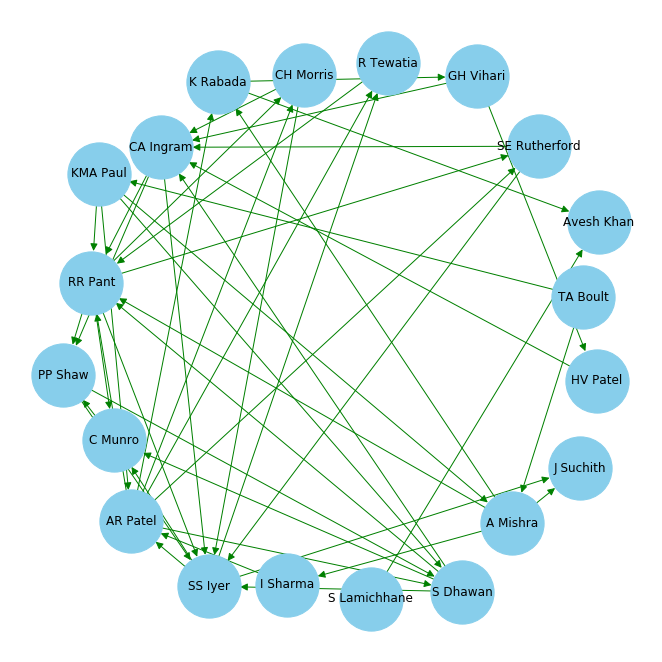

In [14]:
# plot graph
plt.figure(figsize=(9,9))
pos = nx.spring_layout(G, k = 20, seed = 21) # k regulates the distance between nodes
nx.draw(G, 
        with_labels=True,
        node_color='skyblue',
        node_size=4000, 
        pos = pos,
        edgelist=G.edges(), 
        edge_color='g',
        arrowsize=15)
plt.show()


In [23]:
help(nx.MultiDiGraph)

Help on class MultiDiGraph in module networkx.classes.multidigraph:

class MultiDiGraph(networkx.classes.multigraph.MultiGraph, networkx.classes.digraph.DiGraph)
 |  A directed graph class that can store multiedges.
 |  
 |  Multiedges are multiple edges between two nodes.  Each edge
 |  can hold optional data or attributes.
 |  
 |  A MultiDiGraph holds directed edges.  Self loops are allowed.
 |  
 |  Nodes can be arbitrary (hashable) Python objects with optional
 |  key/value attributes. By convention `None` is not used as a node.
 |  
 |  Edges are represented as links between nodes with optional
 |  key/value attributes.
 |  
 |  Parameters
 |  ----------
 |  incoming_graph_data : input graph (optional, default: None)
 |      Data to initialize graph. If None (default) an empty
 |      graph is created.  The data can be any format that is supported
 |      by the to_networkx_graph() function, currently including edge list,
 |      dict of dicts, dict of lists, NetworkX graph, NumP

In [24]:
list(G.edges)

[('PP Shaw', 'S Dhawan', 0),
 ('PP Shaw', 'SS Iyer', 0),
 ('S Dhawan', 'SS Iyer', 0),
 ('S Dhawan', 'CA Ingram', 0),
 ('S Dhawan', 'RR Pant', 0),
 ('S Dhawan', 'C Munro', 0),
 ('SS Iyer', 'R Tewatia', 0),
 ('SS Iyer', 'C Munro', 0),
 ('SS Iyer', 'AR Patel', 0),
 ('SS Iyer', 'J Suchith', 0),
 ('CA Ingram', 'PP Shaw', 0),
 ('CA Ingram', 'RR Pant', 0),
 ('CA Ingram', 'SS Iyer', 0),
 ('RR Pant', 'PP Shaw', 0),
 ('RR Pant', 'SS Iyer', 0),
 ('RR Pant', 'CH Morris', 0),
 ('RR Pant', 'SE Rutherford', 0),
 ('RR Pant', 'C Munro', 0),
 ('KMA Paul', 'RR Pant', 0),
 ('KMA Paul', 'S Dhawan', 0),
 ('KMA Paul', 'AR Patel', 0),
 ('KMA Paul', 'A Mishra', 0),
 ('AR Patel', 'RR Pant', 0),
 ('AR Patel', 'S Dhawan', 0),
 ('AR Patel', 'R Tewatia', 0),
 ('AR Patel', 'CH Morris', 0),
 ('AR Patel', 'K Rabada', 0),
 ('AR Patel', 'SE Rutherford', 0),
 ('R Tewatia', 'RR Pant', 0),
 ('GH Vihari', 'CA Ingram', 0),
 ('GH Vihari', 'HV Patel', 0),
 ('HV Patel', 'CA Ingram', 0),
 ('CH Morris', 'CA Ingram', 0),
 ('CH Mor

In [15]:
list(G.degree)

[('PP Shaw', 5),
 ('S Dhawan', 7),
 ('SS Iyer', 10),
 ('CA Ingram', 8),
 ('RR Pant', 11),
 ('KMA Paul', 5),
 ('AR Patel', 9),
 ('R Tewatia', 3),
 ('GH Vihari', 3),
 ('HV Patel', 2),
 ('CH Morris', 4),
 ('K Rabada', 4),
 ('Avesh Khan', 2),
 ('S Lamichhane', 1),
 ('I Sharma', 2),
 ('C Munro', 4),
 ('A Mishra', 6),
 ('SE Rutherford', 4),
 ('J Suchith', 2),
 ('TA Boult', 2)]

In [16]:
list(G.in_degree)

[('PP Shaw', 3),
 ('S Dhawan', 3),
 ('SS Iyer', 6),
 ('CA Ingram', 5),
 ('RR Pant', 6),
 ('KMA Paul', 1),
 ('AR Patel', 3),
 ('R Tewatia', 2),
 ('GH Vihari', 1),
 ('HV Patel', 1),
 ('CH Morris', 2),
 ('K Rabada', 2),
 ('Avesh Khan', 2),
 ('S Lamichhane', 0),
 ('I Sharma', 1),
 ('C Munro', 3),
 ('A Mishra', 2),
 ('SE Rutherford', 2),
 ('J Suchith', 2),
 ('TA Boult', 0)]